<a href="https://colab.research.google.com/github/UNB-TME-6017-W24/assignment-4-image-segmentation-darthvader998/blob/main/3721371_TMEAssign4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Research and Model Selection**


The U-Net model was chosen for its exceptional performance in image segmentation tasks, particularly noted for its ability to capture fine details and maintain spatial hierarchies. The architecture's symmetric design and skip connections efficiently propagate context information, enhancing segmentation accuracy.[1] The Oxford-IIIT Pet Dataset's diverse content, including varying lighting conditions and cluttered backgrounds, tests the model's adaptability and robustness.

Reason for choosing U-Net over other models:

- U-Net's symmetric design and skip connections facilitate efficient context propagation, ideal for tasks requiring precise segmentation.
- The dataset's intricate details and diverse content demand a model capable of capturing fine-grained features, a strength of U-Net.
- U-Net's proficiency in handling small datasets and producing high-quality segmentations with limited annotations aligns well with the dataset's characteristics, ensuring effective utilization of available data.



# **2. Data Collection and Preparation**

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U keras
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

In [ ]:
#importing necessary libraries
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
# Load the Oxford-IIIT Pet Dataset with TensorFlow Datasets [2]
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3Y0WYH/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3Y0WYH/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Normalizing the input image data to [0, 1] and adjusting the mask labels.
Masks are decremented by 1 to match the range of target labels that starts from 0.
    

In [ ]:
# Function to normalize images and masks
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

Resizing the input image and masking to the desired size for the model input and normalizing them.

In [ ]:
# Function to load and process images and masks
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so using the same splits:

In [ ]:
# Preparing the training and testing datasets
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image horizontally and returns Augmented images and masks. [5]


In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Building the input pipeline, applying the augmentation after batching the inputs:

In [ ]:
# Configuring the train and test batch datasets
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualizing an image example and its corresponding mask from the dataset:

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

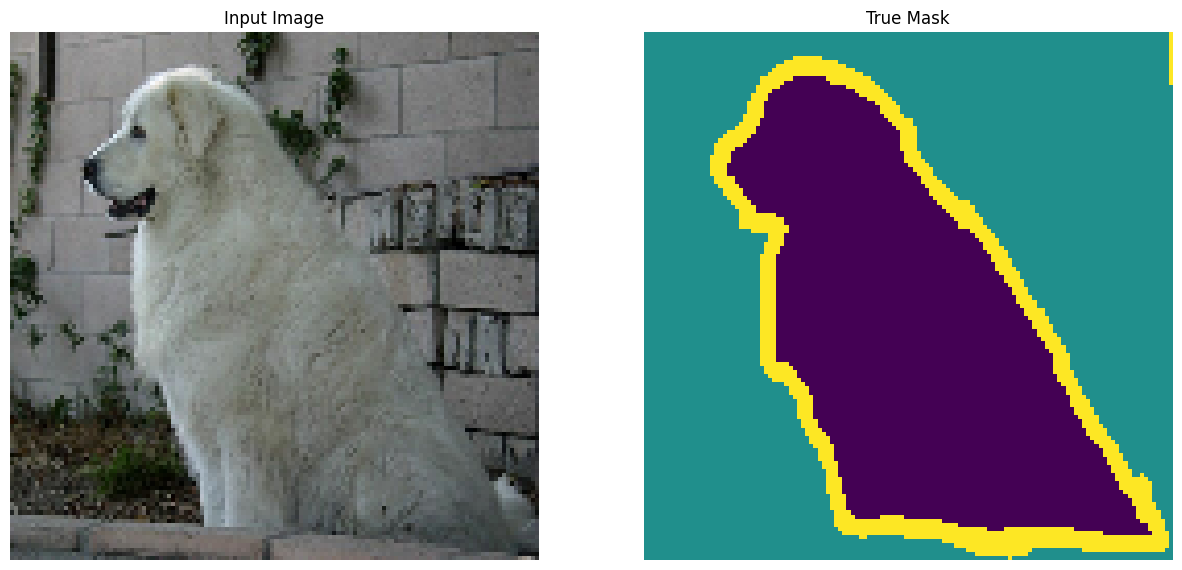

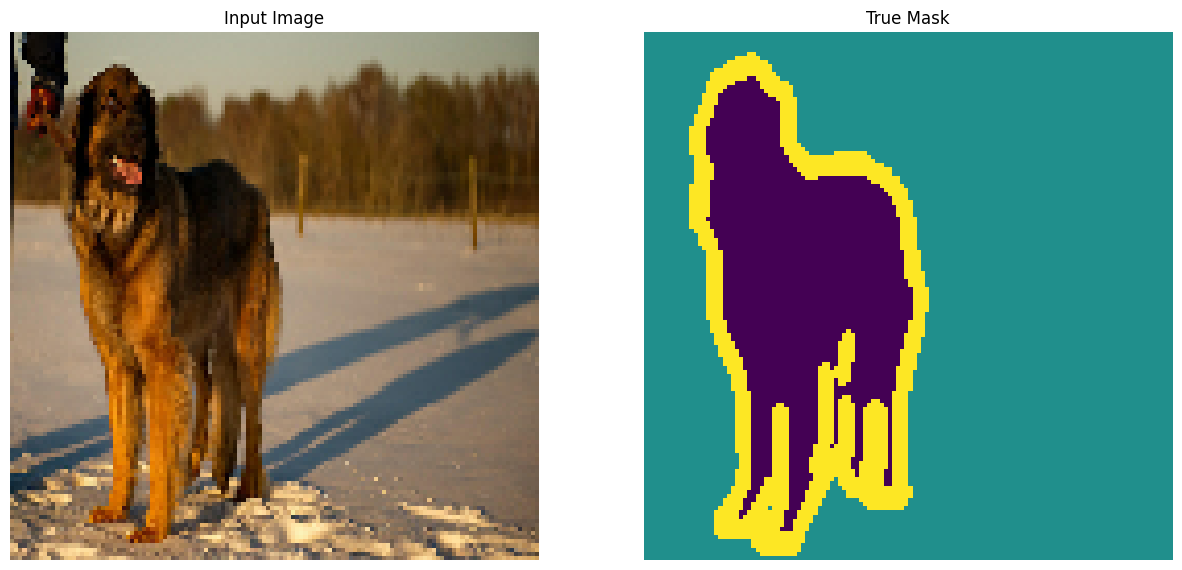

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# **3. Implementation**

The model implemented here is a modified version of U-Net, which includes an encoder (downsampler) and a decoder (upsampler). To enhance the robustness of the feature extraction and minimize the number of parameters that require training, a pretrained MobileNetV2 is utilized as the encoder. The decoder employs an upsample block that has been previously developed in the pix2pix example found within the TensorFlow Examples repository. [3] [4] [6]



As mentioned, the encoder is a pretrained MobileNetV2 model. Used the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Also, the encoder will not be trained during the training process to leverage its robust pre-trained features for efficient learning, prevent overfitting on the smaller target dataset, and reduce the computational load.

In [ ]:
# Model architecture setup using MobileNetV2 as the backbone for a U-Net model [3]
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Using the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Creating the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In the architecture being described below, the part of the model responsible for increasing the resolution of feature maps (decoder or upsampler) consists of multiple "upsample blocks." These blocks are predefined components available in the TensorFlow examples repository, which systematically enlarge the spatial dimensions of the input feature maps to reconstruct the image at its original size or a target resolution. This process typically involves operations such as convolutional layers, batch normalization, and upsampling techniques like transposed convolutions or bilinear interpolation, designed to refine and detail the output from the encoder, thus effectively segmenting the image.

In [ ]:
# Defining the upsampling stack using pix2pix upsampling layers
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
# U-Net model construction
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

The number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

Training the model:

Since this is a multiclass classification problem, using the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.


When the model makes predictions, it outputs a set of scores for each class at each pixel. The task during inference is to decide which class each pixel belongs to based on these scores.

- **Highest Value Channel**: The label assigned to each pixel is determined by identifying which class (or channel, in the context of the output tensor) has the highest score for that pixel. This is the essence of what happens in classification — the class with the highest likelihood, as determined by the model's output, is chosen as the prediction.

- **`create_mask` Function**: This function operationalizes the above process by taking the model's predictions (logits), applying an `argmax` operation across the channels, and thus extracting the index (or class) with the highest value at each pixel. The `argmax` function effectively "creates a mask" where each pixel's value is the index (class) of the highest logit value, turning the logits into a categorical mask that can be compared to the true labels for evaluation or visualized for inspection.

This setup ensures that the network learns to classify each pixel correctly by comparing its predictions directly against the true class labels, and the efficiency of inference is maintained by simplifying the final output into a straightforward class per pixel decision.


In [ ]:
# Model instantiation and compilation
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# **4. Analysis and Discussion**

Trying out the model to check what it predicts before training:

In [ ]:
#Creating a segmentation mask from the model's predictions.
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
#Displaying the model's predictions along with the corresponding input images and true masks.
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


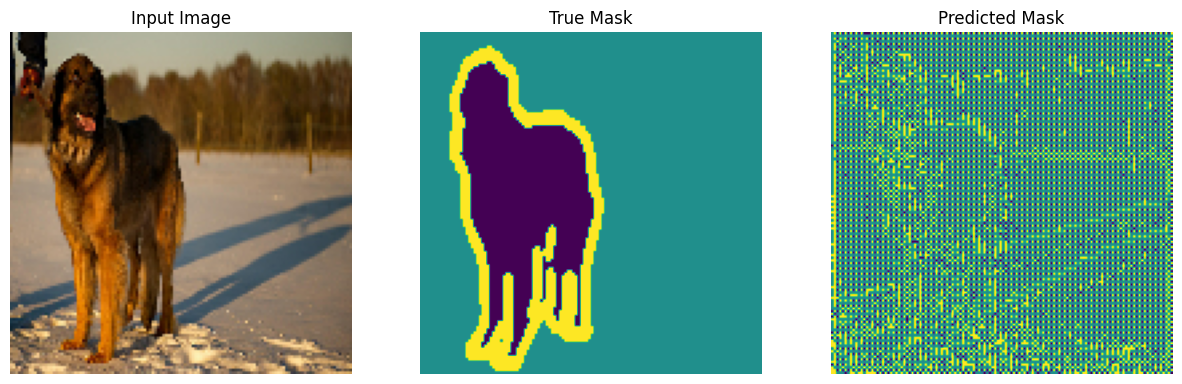

In [ ]:
show_predictions()

As we can observe, the model's current state before training is not yielding satisfactory segmentation results. It requires further investigation into model training, data augmentation, or potentially post-processing techniques to improve the clarity and accuracy of the predicted segmentation.

**Training the model further to see more enhanced results**

The callback defined below is used to observe how the model improves while it is training during each epoch,

In [ ]:
#Callback Function to execute actions at the end of each epoch
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


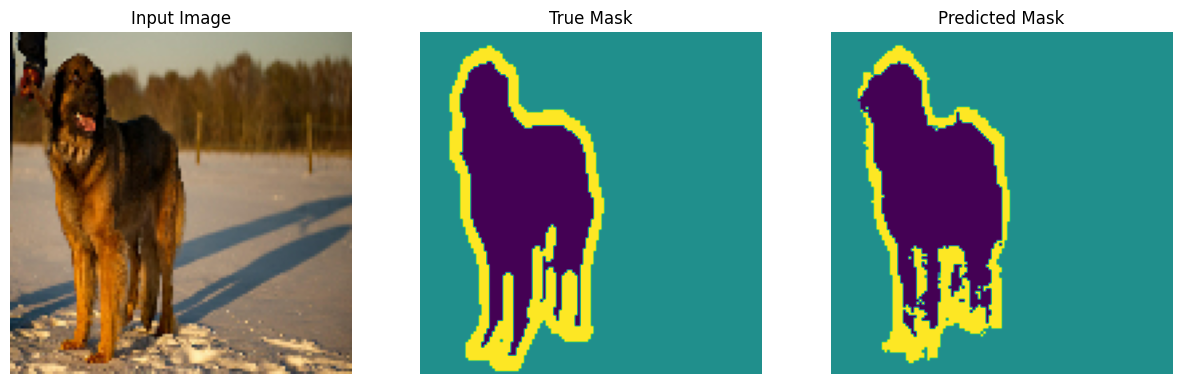


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9281 - loss: 0.1761 - val_accuracy: 0.9021 - val_loss: 0.2622


In [ ]:
#Setting training parameters, training, and evaluating model performance with visual feedback at each epoch end.
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

As we can see the results after training are better now, as the model is on the right track, capturing the overall shape of the dog, it still needs refinement to more accurately capture the segmentation boundaries. This could potentially be improved by additional training epochs.

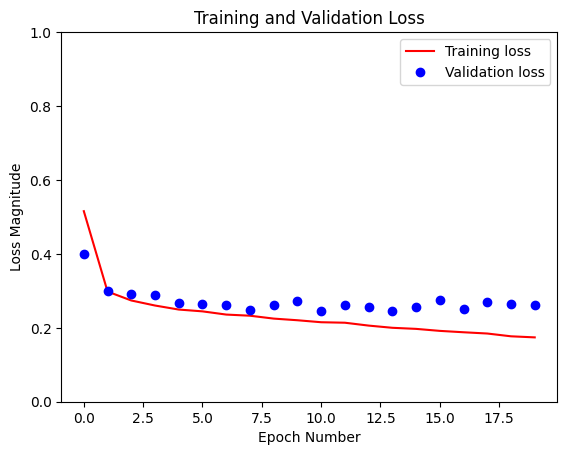

In [ ]:
# Plotting training and validation loss
training_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']
plt.figure()
plt.plot(model_history.epoch, training_loss, 'r', label='Training loss')
plt.plot(model_history.epoch, validation_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Magnitude')
plt.ylim([0, 1])
plt.legend()
plt.show()

As we can see the training loss decreases significantly at the start and then plateaus, which indicates that the model is learning and improving its performance on the training dataset over time. The flattening of the curve suggests that the model may be beginning to converge, with diminishing returns on loss reduction with each subsequent epoch.
The validation loss is initially higher than the training loss but quickly converges to a similar value, staying relatively constant throughout the remaining epochs. This close alignment of the two curves without a wide gap implies that the model is generalizing well to unseen data, i.e., it is not overfitting.
The fact that the validation loss does not increase over time is a good sign; it means that the model is not memorizing the training data but is learning general features that are applicable to the validation data as well.

Making some prediction with small number of epochs

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


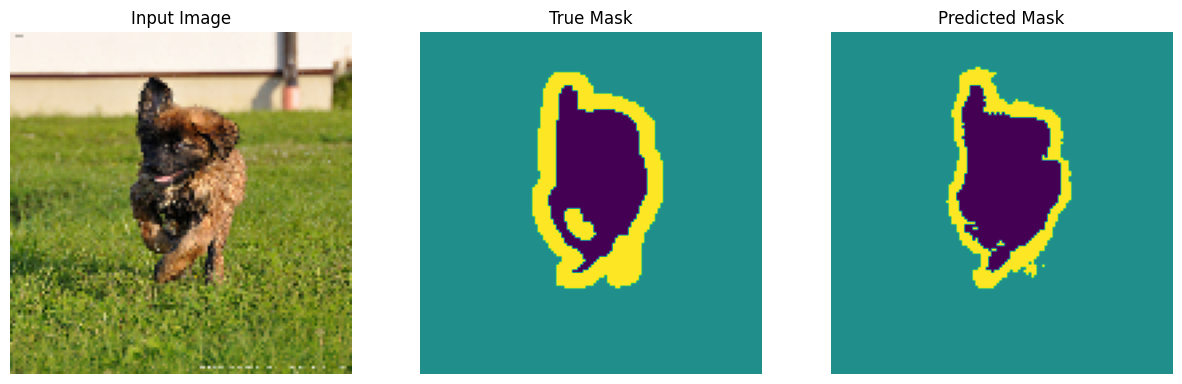

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


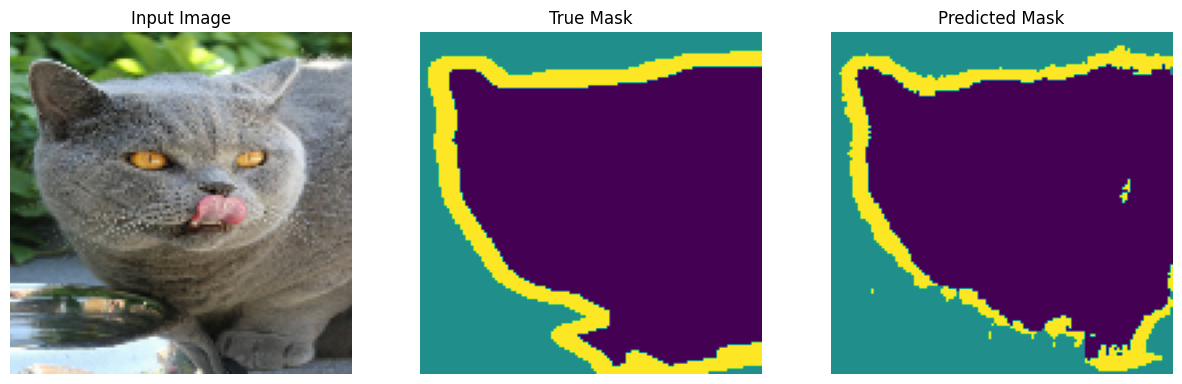

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


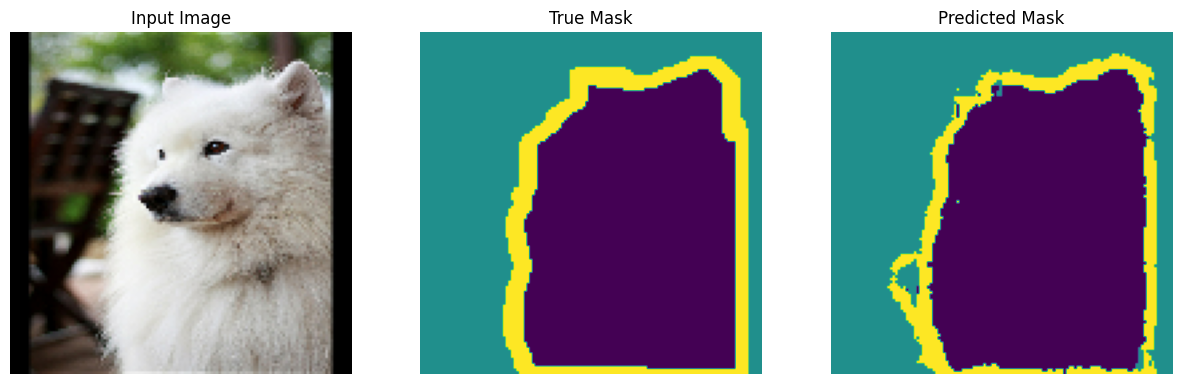

In [ ]:
show_predictions(test_batches, 3)

As we can see from the predicted mask captures the overall shape but has some inaccuracies.

First output: The segmentation model has difficulty with motion blur and accurately delineating the dog from the grass, which results in an inaccurate predicted mask.

Second Output: The model performs better but still struggles slightly with the fur's texture, leading to a small discrepancy along the edges between the true mask and the predicted mask.

Third Output: The model shows a noticeable mismatch in the predicted mask, particularly around the more detailed areas such as the tail and whiskers, indicating a challenge with fine details and possibly with differentiating between similar textures or colors.

Across these examples, the model seems to perform variably, with challenges in motion blur, fine textures, and detailed edges

The segmentation model demonstrates a promising ability to distinguish subjects from their backgrounds but struggles with motion blur and fine details, as seen in the varied results with the dog and cat images. Future improvements could include enhancing the model's robustness to motion and texture by incorporating additional diverse training data and potentially exploring more complex architectures like attention mechanisms. Further research could also investigate post-processing techniques to refine the edges and details of the predicted masks.

**References:**


[1] https://www.analyticsvidhya.com/blog/2022/10/image-segmentation-with-u-net/

[2] https://www.robots.ox.ac.uk/%7Evgg/data/pets/

[3] https://www.tensorflow.org/tutorials/images/segmentation

[4] https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

[5] https://www.tensorflow.org/tutorials/images/data_augmentation

[6] https://www.tensorflow.org/tutorials/generative/pix2pix